In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf
from keras import regularizers

/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 21 # the number of joints
        self.joint_d = 3 # the dimension of joint
        self.joint_ind = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
        self.key_ind = np.array([1,3,7,11,14,18])
        self.feat_d = 252
        self.filters = 64
        self.clc_num=49
C = Config()

In [4]:
from scipy.spatial.distance import cdist

def get_CG_double(p_0,p_1,C):
    M_0 = []
    M_1 = []

    for f in range(C.frame_l):
        #correlation graph 
        d_m_0 = cdist(p_0[f][C.key_ind,:],p_0[f],'euclidean').flatten()
        d_m_1 = cdist(p_1[f][C.key_ind,:],p_1[f],'euclidean').flatten()
        d_m_01 = cdist(p_0[f][C.key_ind,:],p_1[f],'euclidean').flatten()
        d_m_10 = cdist(p_1[f][C.key_ind,:],p_0[f],'euclidean').flatten() 
        
        M_0.append(np.concatenate([d_m_0,d_m_01]))
        M_1.append(np.concatenate([d_m_1,d_m_10]))
 
    M_0 = np.stack(M_0)
    M_1 = np.stack(M_1)   
    return M_0,M_1

# Building the model

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    #P_diff_slow = Lambda(lambda x: tf.norm(x,axis=-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    #P_diff_fast = Lambda(lambda x: tf.norm(x,axis=-1))(P_diff_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x

def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=21,joint_d=3,feat_d=210,filters=128):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.05)(x)
    x = c1D(x,filters,3)
    x = block(x,filters)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.05)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.05)(x_d_slow)
    x_d_slow = block(x_d_slow,filters)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.05)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.05)(x_d_fast)
    x_d_fast = block(x_d_fast,filters) 
    x_d_fast = SpatialDropout1D(0.05)(x_d_fast)
    
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.2)(x)
    
    x = block(x,filters*8)
    x = SpatialDropout1D(0.2)(x)

    return Model(inputs=[M,P],outputs=x)

In [6]:
def build_AR_double(C):
    M_0 = Input(name='M_0', shape=(C.frame_l,C.feat_d))  
    M_1 = Input(name='M_1', shape=(C.frame_l,C.feat_d))
    P_0 = Input(name='P_0', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    P_1 = Input(name='P_1', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x_0 = FM([M_0,P_0])
    x_1 = FM([M_1,P_1])
    
    x = maximum([x_0,x_1])
    
    x = GlobalMaxPool1D()(x)

    x = d1D(x,256)
    x = Dropout(0.5)(x)
    x = d1D(x,256)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M_0,M_1,P_0,P_1],outputs=x)
    return model


In [7]:
AR_double = build_AR_double(C)

In [8]:
AR_double.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M_0 (InputLayer)                (None, 32, 252)      0                                            
__________________________________________________________________________________________________
P_0 (InputLayer)                (None, 32, 21, 3)    0                                            
__________________________________________________________________________________________________
M_1 (InputLayer)                (None, 32, 252)      0                                            
__________________________________________________________________________________________________
P_1 (InputLayer)                (None, 32, 21, 3)    0                                            
__________________________________________________________________________________________________
model_1 (M

In [9]:
AR_double.load_weights('weights/weight_xo_1D_double_aug.h5')

## Assign the data path

In [10]:
data_path = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/NTU/'
xlist = ['xview_train.pkl','xview_val.pkl','xsub_train.pkl','xsub_val.pkl']

## Cross view train

In [11]:
xobj_train = pd.read_pickle(data_path+xlist[2],compression='gzip')

## Without frame_sampling

In [13]:
X_0 = []
X_1 = []
X_2 = []
X_3 = []
Y = []
num_xobj_train = len(xobj_train['label'])
for i in tqdm(range(num_xobj_train)): 
    p_0 = xobj_train['poses'][i][0][:,C.joint_ind,:]
    p_1 = xobj_train['poses'][i][1][:,C.joint_ind,:]

    if np.all(p_0==0) or np.all(p_1==0): 
        continue
           
    p_0 = zoom(p_0,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p_1 = zoom(p_1,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    
    try:
        label = np.zeros(11)
        label[xobj_train['label'][i]-50] = 1   
    except:
        continue
        #print(xobj_train['name'][i])

    M_0,M_1 = get_CG_double(p_0,p_1,C)

    X_0.append(M_0)
    X_1.append(M_1)
    X_2.append(p_0)
    X_3.append(p_1)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
X_2 = np.stack(X_2)  
X_3 = np.stack(X_3) 
Y = np.stack(Y)


  0%|          | 51/40091 [00:00<01:21, 489.70it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 40091/40091 [01:06<00:00, 601.68it/s]


In [19]:
import keras
lr = 1e-5
AR_double.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8, patience=5, cooldown=5, min_lr=5e-6)
history = AR_double.fit([X_0,X_1,X_2,X_3],Y,
        batch_size=2048,
        epochs=300,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_TEST_0,X_TEST_1,X_TEST_2,X_TEST_3],Y_TEST)      
        )

Train on 7423 samples, validate on 3022 samples
Epoch 1/300
7423/7423 [==============================] - 9s 1ms/step - loss: 0.0540 - acc: 0.9841 - val_loss: 0.2971 - val_acc: 0.9136
Epoch 2/300
7423/7423 [==============================] - 2s 203us/step - loss: 0.0540 - acc: 0.9838 - val_loss: 0.2981 - val_acc: 0.9136
Epoch 3/300
7423/7423 [==============================] - 2s 215us/step - loss: 0.0481 - acc: 0.9869 - val_loss: 0.3001 - val_acc: 0.9166
Epoch 4/300
7423/7423 [==============================] - 2s 213us/step - loss: 0.0516 - acc: 0.9848 - val_loss: 0.2963 - val_acc: 0.9153
Epoch 5/300
7423/7423 [==============================] - 2s 220us/step - loss: 0.0478 - acc: 0.9860 - val_loss: 0.3004 - val_acc: 0.9153
Epoch 6/300
7423/7423 [==============================] - 2s 205us/step - loss: 0.0515 - acc: 0.9852 - val_loss: 0.2952 - val_acc: 0.9153
Epoch 7/300
7423/7423 [==============================] - 2s 207us/step - loss: 0.0542 - acc: 0.9855 - val_loss: 0.2984 - val_acc: 0.

7423/7423 [==============================] - 2s 209us/step - loss: 0.0466 - acc: 0.9875 - val_loss: 0.3035 - val_acc: 0.9136
Epoch 120/300
7423/7423 [==============================] - 2s 213us/step - loss: 0.0463 - acc: 0.9881 - val_loss: 0.2953 - val_acc: 0.9189
Epoch 121/300
7423/7423 [==============================] - 1s 201us/step - loss: 0.0448 - acc: 0.9885 - val_loss: 0.3031 - val_acc: 0.9136
Epoch 122/300
7423/7423 [==============================] - 2s 206us/step - loss: 0.0405 - acc: 0.9900 - val_loss: 0.3026 - val_acc: 0.9153
Epoch 123/300
7423/7423 [==============================] - 2s 212us/step - loss: 0.0432 - acc: 0.9883 - val_loss: 0.3044 - val_acc: 0.9140
Epoch 124/300
7423/7423 [==============================] - 2s 212us/step - loss: 0.0422 - acc: 0.9887 - val_loss: 0.3002 - val_acc: 0.9159
Epoch 125/300
7423/7423 [==============================] - 2s 208us/step - loss: 0.0437 - acc: 0.9883 - val_loss: 0.2957 - val_acc: 0.9176
Epoch 126/300
7423/7423 [================

7423/7423 [==============================] - 2s 212us/step - loss: 0.0444 - acc: 0.9877 - val_loss: 0.3016 - val_acc: 0.9166
Epoch 179/300
7423/7423 [==============================] - 2s 206us/step - loss: 0.0414 - acc: 0.9895 - val_loss: 0.2945 - val_acc: 0.9183
Epoch 180/300
7423/7423 [==============================] - 2s 204us/step - loss: 0.0413 - acc: 0.9891 - val_loss: 0.3028 - val_acc: 0.9146
Epoch 181/300
7423/7423 [==============================] - 2s 218us/step - loss: 0.0417 - acc: 0.9891 - val_loss: 0.2991 - val_acc: 0.9179
Epoch 182/300
7423/7423 [==============================] - 2s 208us/step - loss: 0.0438 - acc: 0.9871 - val_loss: 0.3025 - val_acc: 0.9159
Epoch 183/300
7423/7423 [==============================] - 2s 215us/step - loss: 0.0419 - acc: 0.9894 - val_loss: 0.3028 - val_acc: 0.9153
Epoch 184/300
7423/7423 [==============================] - 2s 209us/step - loss: 0.0448 - acc: 0.9885 - val_loss: 0.3024 - val_acc: 0.9169
Epoch 185/300
7423/7423 [================

7423/7423 [==============================] - 2s 213us/step - loss: 0.0421 - acc: 0.9881 - val_loss: 0.3035 - val_acc: 0.9173
Epoch 238/300
7423/7423 [==============================] - 2s 214us/step - loss: 0.0425 - acc: 0.9891 - val_loss: 0.3105 - val_acc: 0.9163
Epoch 239/300
7423/7423 [==============================] - 2s 219us/step - loss: 0.0397 - acc: 0.9887 - val_loss: 0.3091 - val_acc: 0.9146
Epoch 240/300
7423/7423 [==============================] - 2s 213us/step - loss: 0.0393 - acc: 0.9904 - val_loss: 0.3024 - val_acc: 0.9193
Epoch 241/300
7423/7423 [==============================] - 2s 213us/step - loss: 0.0403 - acc: 0.9884 - val_loss: 0.3090 - val_acc: 0.9140
Epoch 242/300
7423/7423 [==============================] - 2s 205us/step - loss: 0.0431 - acc: 0.9876 - val_loss: 0.3051 - val_acc: 0.9153
Epoch 243/300
7423/7423 [==============================] - 2s 208us/step - loss: 0.0411 - acc: 0.9890 - val_loss: 0.3052 - val_acc: 0.9159
Epoch 244/300
7423/7423 [================

7423/7423 [==============================] - 2s 209us/step - loss: 0.0379 - acc: 0.9903 - val_loss: 0.3043 - val_acc: 0.9196
Epoch 297/300
7423/7423 [==============================] - 2s 218us/step - loss: 0.0404 - acc: 0.9891 - val_loss: 0.3115 - val_acc: 0.9179
Epoch 298/300
7423/7423 [==============================] - 2s 205us/step - loss: 0.0388 - acc: 0.9896 - val_loss: 0.3091 - val_acc: 0.9179
Epoch 299/300
7423/7423 [==============================] - 2s 206us/step - loss: 0.0360 - acc: 0.9899 - val_loss: 0.3088 - val_acc: 0.9179
Epoch 300/300
7423/7423 [==============================] - 2s 211us/step - loss: 0.0359 - acc: 0.9892 - val_loss: 0.3173 - val_acc: 0.9140


In [20]:
AR_double.save_weights('weights/weight_xo_1D_double.h5')

In [18]:
import json
with open('xo_double.json', 'w') as f:
    json.dump(str(history.history), f)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## With frame_sampling

In [28]:
def sampling_frame_double(p_0,p_1,C):
    full_l = p_0.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p_0 = p_0[int(s):int(e),:,:]
        p_1 = p_1[int(s):int(e),:,:]     
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p_0 = p_0[index,:,:]
        p_1 = p_1[index,:,:]
    p_0 = zoom(p_0,C.frame_l,C.joint_n,C.joint_d)
    p_1 = zoom(p_1,C.frame_l,C.joint_n,C.joint_d)
    return p_0,p_1

In [16]:
lr = 3e-5
AR_double.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 200
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    X_2 = []
    X_3 = []
    Y = []

    #for i in tqdm(range(len(xobj_train['label']))): 
    for i in range(len(xobj_train['label'])):
        p_0 = xobj_train['poses'][i][0][:,C.joint_ind,:]
        p_1 = xobj_train['poses'][i][1][:,C.joint_ind,:]
        
        if np.all(p_0==0) or np.all(p_1==0): 
            continue

        p_0,p_1 = sampling_frame_double(p_0,p_1,C)
           
        try:
            label = np.zeros(11)
            label[xobj_train['label'][i]-50] = 1   
        except:
            continue
            #print(xobj_train['name'][i])

        M_0,M_1 = get_CG_double(p_0,p_1,C)
                
        #rotation
        x_angle = np.random.uniform(-0.02,0.02)
        y_angle = np.random.uniform(-np.pi/3,np.pi/3)
        z_angle = np.random.uniform(-0.02,0.02)
        R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
        p_0,p_1 = rotaion_two(p_0,p_1,R)
        
        X_0.append(M_0)
        X_1.append(M_1)
        X_2.append(p_0)
        X_3.append(p_1)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    X_2 = np.stack(X_2)  
    X_3 = np.stack(X_3) 
    Y = np.stack(Y)

    AR_double.fit([X_0,X_1,X_2,X_3],Y,
            batch_size=2048,
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_TEST_0,X_TEST_1,X_TEST_2,X_TEST_3],Y_TEST)
            )

    del X_0
    del X_1
    del X_2
    del X_3
    del Y
    gc.collect()

    if e%10==0:
        AR_double.save_weights('weights/weight_xo_1D_double_aug.h5')
   

epoch0


/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 10s 1ms/step - loss: 0.0437 - acc: 0.9867 - val_loss: 0.3356 - val_acc: 0.9150
epoch1
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 230us/step - loss: 0.0460 - acc: 0.9853 - val_loss: 0.3299 - val_acc: 0.9169
epoch2
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 222us/step - loss: 0.0476 - acc: 0.9865 - val_loss: 0.3218 - val_acc: 0.9176
epoch3
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 214us/step - loss: 0.0464 - acc: 0.9853 - val_loss: 0.3266 - val_acc: 0.9169
epoch4
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 217us/step - loss: 0.0496 - acc: 0.9846 - val_loss: 0.3332 - val_acc: 0.9136
epoch5
Train on 7423 samples, validate on 3022 samples
Epo

epoch43
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 257us/step - loss: 0.0410 - acc: 0.9872 - val_loss: 0.3176 - val_acc: 0.9183
epoch44
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 240us/step - loss: 0.0447 - acc: 0.9861 - val_loss: 0.3140 - val_acc: 0.9193
epoch45
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 240us/step - loss: 0.0399 - acc: 0.9871 - val_loss: 0.3110 - val_acc: 0.9199
epoch46
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 241us/step - loss: 0.0409 - acc: 0.9869 - val_loss: 0.3110 - val_acc: 0.9203
epoch47
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 251us/step - loss: 0.0356 - acc: 0.9891 - val_loss: 0.3024 - val_acc: 0.9169
epoch48
Train on 7423 samples, validate on 30

epoch86
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 225us/step - loss: 0.0376 - acc: 0.9875 - val_loss: 0.3227 - val_acc: 0.9179
epoch87
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 227us/step - loss: 0.0381 - acc: 0.9884 - val_loss: 0.3212 - val_acc: 0.9199
epoch88
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 223us/step - loss: 0.0388 - acc: 0.9895 - val_loss: 0.3275 - val_acc: 0.9173
epoch89
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 232us/step - loss: 0.0397 - acc: 0.9880 - val_loss: 0.3225 - val_acc: 0.9193
epoch90
Train on 7423 samples, validate on 3022 samples
Epoch 1/1
7423/7423 [==============================] - 2s 208us/step - loss: 0.0366 - acc: 0.9887 - val_loss: 0.3370 - val_acc: 0.9176
epoch91
Train on 7423 samples, validate on 30

In [ ]:
AR_double.save_weights('weights/weight_xo_1D_double_aug.h5')

## Cross view validation

In [12]:
xobj_val = pd.read_pickle(data_path+xlist[3],compression='gzip')

In [13]:
X_TEST_0 = []
X_TEST_1 = []
X_TEST_2 = []
X_TEST_3 = []
Y_TEST = []
num_xobj_val = len(xobj_val['label'])
for i in tqdm(range(num_xobj_val)): 
    p_0 = xobj_val['poses'][i][0][:,C.joint_ind,:]
    p_1 = xobj_val['poses'][i][1][:,C.joint_ind,:]

    if np.all(p_0==0) or np.all(p_1==0): 
        continue
           
    p_0 = zoom(p_0,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p_1 = zoom(p_1,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    
    try:
        label = np.zeros(11)
        label[xobj_val['label'][i]-50] = 1   
    except:
        continue
        #print(xobj_val['name'][i])

    M_0,M_1 = get_CG_double(p_0,p_1,C)

    X_TEST_0.append(M_0)
    X_TEST_1.append(M_1)
    X_TEST_2.append(p_0)
    X_TEST_3.append(p_1)
    Y_TEST.append(label)

X_TEST_0 = np.stack(X_TEST_0)  
X_TEST_1 = np.stack(X_TEST_1) 
X_TEST_2 = np.stack(X_TEST_2)  
X_TEST_3 = np.stack(X_TEST_3) 
Y_TEST = np.stack(Y_TEST)


  0%|          | 0/16487 [00:00<?, ?it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 16487/16487 [00:27<00:00, 625.48it/s]


In [14]:
Y_pred = AR_double.predict([X_TEST_0,X_TEST_1,X_TEST_2,X_TEST_3])
acc = 1-np.count_nonzero(np.argmax(Y_pred,axis=1)-np.argmax(Y_TEST,axis=1))/Y_TEST.shape[0]
print('Accuracy:',acc)

Accuracy: 0.9192587690271343


In [20]:
len(Y_TEST)

3022

In [15]:
(3022*92.3+14901*82)/(14901+3022)

83.68610165708866

In [19]:
0.9334877564526803

0.9301786896095301

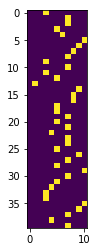

In [21]:
plt.imshow(Y_TEST[200:240,:])
plt.show()

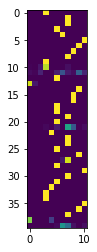

In [23]:
plt.imshow(Y_pred[200:240,:])
plt.show()

In [9]:
for i in range(1):  
    p_0 = xobj_val['poses'][i][0]
    p_1 = xobj_val['poses'][i][1]
    
    p_0 = zoom(p_0,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p_1 = zoom(p_1,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

In [39]:
np.all(p_1!=0)

False

In [38]:
np.all(p_0!=0)

True

In [41]:
M_0,M_1,M_01,M_10 = get_distance_matrix(p_0,p_1)

In [12]:
def sampling_train_a(p_0,p_1,C,rate=0.8):
    #two person with aligment
    full_l = p_0.shape[0] # full length
    valid_l = np.round(np.random.uniform(rate,1)*full_l) #valid lenghth for training
    s = random.randint(0, full_l-int(valid_l))
    e = s+valid_l # sample end point
    p_0 = p_0[int(s):int(e),:,:]
    p_1 = p_1[int(s):int(e),:,:]
    p_0 = zoom(p_0,C.frame_l,C.joint_n,C.joint_d)
    p_1 = zoom(p_1,C.frame_l,C.joint_n,C.joint_d)
    return p_0,p_1

def sampling_train_b(p,C,rate=0.9):
    #two person without aligment
    full_l = p.shape[0] # full length
    valid_l = np.round(np.random.uniform(rate,1)*full_l)
    index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False)) 
    p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

In [14]:
iu = np.triu_indices(25,0) # the index of up triangle of matrix
f=0
#distance max 
d_m_0 = cdist(p_0[f],p_0[f],'euclidean')
len(d_m_0[iu])

325

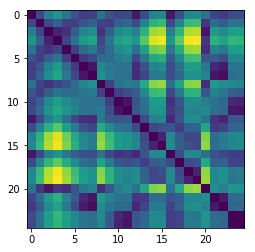

In [15]:
plt.imshow(d_m_0)
plt.show()

In [ ]:
plt.imshow(p_0[0])
def poses_diff(x):
    x = tf.convert_to_tensor(x, np.float32)
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    #x = ZeroPadding2D(padding=((0, 1),(0,0)))(x)
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x
plt.imshow(K.eval(poses_diff(p_0))[0])